# Base Model - using LSTM

- Train: 75Agree_train
- Test: 75Agree_test

In [25]:
import numpy as np
import random
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

### Step 1: Prepate the data to feed the model

In [26]:
# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_54862/918004758.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    336
1    336
2    336
Name: count, dtype: int64

### Step 2: Train the model with fine-tuned hyperparameters

In [27]:
# tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['sentence'])

X_train_seq = tokenizer.texts_to_sequences(df_train['sentence'])
X_test_seq = tokenizer.texts_to_sequences(df_test['sentence'])

# padding
lengths = df_train['sentence'].str.split().apply(len)
maxlen = int(np.percentile(lengths, 95))

X_train = pad_sequences(X_train_seq, maxlen=maxlen)
X_test = pad_sequences(X_test_seq, maxlen=maxlen)

# labels
y_train = df_train['label'].values
y_test = df_test['label'].values

In [28]:
def get_hyperparameters():
    return {
        "embedding_dim": random.choice([64, 128, 256]), #32, 64, 128, 256
        "lstm_units": random.choice([64, 128, 256]), #32, 64, 128, 256
        "epochs": random.choice([5, 8, 10, 15]), #2, 3, 5, 8, 10, 15
        "lr": random.choice([1e-4, 1e-5]), #1e-3, 5e-4, 1e-4, 1e-5
        "dropout": random.choice([0.3, 0.5]), #0.2, 0.3, 0.5
        "recurrent_dropout": random.choice([0.2, 0.3, 0.5]) #0.0, 0.2, 0.3, 0.5
    }

# cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

try:
    all_results = pd.read_csv("model LSTM (2).csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["embedding_dim", "lstm_units", "epochs", "lr", "dropout", "recurrent_dropout", "valloss"])


for _ in range(10):
    current_hyperparams = get_hyperparameters()
    current_results = {"embedding_dim": [], "lstm_units": [], "epochs": [], "lr": [], "dropout": [], "recurrent_dropout": [], "valloss": []}
    current_valloss = 0

    mask = (
        (all_results['embedding_dim'] == current_hyperparams['embedding_dim']) &
        (all_results['lstm_units'] == current_hyperparams['lstm_units']) &
        (all_results['epochs'] == current_hyperparams['epochs']) &
        (all_results['lr'] == current_hyperparams['lr']) &
        (all_results['dropout'] == current_hyperparams['dropout']) &
        (all_results['recurrent_dropout'] == current_hyperparams['recurrent_dropout'])
    )

    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparams}")

    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold + 1}", end=' | ')

        # split data
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        y_train_fold = to_categorical(y_train_fold, num_classes=3)
        y_val_fold = to_categorical(y_val_fold, num_classes=3)

        # model definition
        model = Sequential([
            Embedding(input_dim=10000, output_dim=current_hyperparams['embedding_dim'], input_length=maxlen),
            LSTM(current_hyperparams['lstm_units'],
                dropout=current_hyperparams['dropout'],
                recurrent_dropout=current_hyperparams['recurrent_dropout'],
                return_sequences=True,
                kernel_regularizer=l2(0.01)),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(current_hyperparams['dropout']),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(current_hyperparams['dropout']),
            Dense(3, activation='softmax')
        ])

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=current_hyperparams['lr']),
            metrics=['accuracy']
        )

        # train
        history = model.fit(X_train_fold, y_train_fold, epochs=current_hyperparams['epochs'], batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=0)

        # evaluate
        val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)[0]
        print(f"Validation Loss: {val_loss}")

        current_valloss += val_loss

    current_valloss /= skf.n_splits
    current_results['embedding_dim'].append(current_hyperparams['embedding_dim'])
    current_results['lstm_units'].append(current_hyperparams['lstm_units'])
    current_results['epochs'].append(current_hyperparams['epochs'])
    current_results['lr'].append(current_hyperparams['lr'])
    current_results['dropout'].append(current_hyperparams['dropout'])
    current_results['recurrent_dropout'].append(current_hyperparams['recurrent_dropout'])
    current_results['valloss'].append(current_valloss)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)
    all_results.to_csv("model LSTM (2).csv", index=False)

"Hyperparameter tuning completed. Results saved to model LSTM (2).csv."

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Evaluating hyperparameters: {'embedding_dim': 64, 'lstm_units': 256, 'epochs': 8, 'lr': 0.0001, 'dropout': 0.3, 'recurrent_dropout': 0.3}
Fold 1 | Validation Loss: 1.9279118776321411
Fold 2 | Validation Loss: 1.9296995401382446
Fold 3 | Validation Loss: 1.9281470775604248
Fold 4 | Validation Loss: 1.948845386505127
Fold 5 | Validation Loss: 1.9409841299057007
Evaluating hyperparameters: {'embedding_dim': 128, 'lstm_units': 256, 'epochs': 15, 'lr': 1e-05, 'dropout': 0.5, 'recurrent_dropout': 0.2}
Fold 1 | 

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Loss: 3.3792636394500732
Fold 2 | Validation Loss: 3.3043019771575928
Fold 3 | Validation Loss: 3.635162115097046
Fold 4 | Validation Loss: 3.3674545288085938
Fold 5 | Validation Loss: 3.4364664554595947
Evaluating hyperparameters: {'embedding_dim': 128, 'lstm_units': 256, 'epochs': 5, 'lr': 1e-05, 'dropout': 0.3, 'recurrent_dropout': 0.5}
Fold 1 | 

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validation Loss: 3.4205875396728516
Fold 2 | Validation Loss: 3.4485597610473633
Fold 3 | 

KeyboardInterrupt: 

In [ ]:
all_results = all_results.sort_values(by="valloss").reset_index(drop=True)
all_results.to_csv("model LSTM (2).csv", index=False)

print(f"Top 3 hyperparameter configurations based on validation loss from {all_results.shape[0]} trials:")

all_results.head(3)

Top 3 hyperparameter configurations based on validation loss from 10 trials:


,embedding_dim,lstm_units,epochs,lr,dropout,recurrent_dropout,valloss
0,64,64,15,0.00010,0.5,0.3,1.949372
1,64,128,10,0.00001,0.5,0.3,2.301124
2,64,128,15,0.00001,0.5,0.2,2.349556


In [ ]:
best_hyperparams = all_results.iloc[0]

# convert the hyperparameters to the correct types
best_hyperparams = {
    "embedding_dim": int(best_hyperparams['embedding_dim']),
    "lstm_units": int(best_hyperparams['lstm_units']),
    "epochs": int(best_hyperparams['epochs']),
    "lr": float(best_hyperparams['lr']),
    "dropout": float(best_hyperparams['dropout']),
    "recurrent_dropout": float(best_hyperparams['recurrent_dropout'])
}

# final model with the best hyperparameters
model = Sequential([
    Embedding(input_dim=10000, output_dim=best_hyperparams['embedding_dim'], input_length=maxlen),
    LSTM(best_hyperparams['lstm_units'],
        dropout=best_hyperparams['dropout'],
        recurrent_dropout=best_hyperparams['recurrent_dropout'],
        return_sequences=True,
        kernel_regularizer=l2(0.01)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(best_hyperparams['dropout']),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(best_hyperparams['dropout']),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=best_hyperparams['lr']),
    metrics=['accuracy']
)

# train
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
history = model.fit(X_train, y_train, epochs=best_hyperparams['epochs'], batch_size=32, validation_data=(X_test, y_test), verbose=0)

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


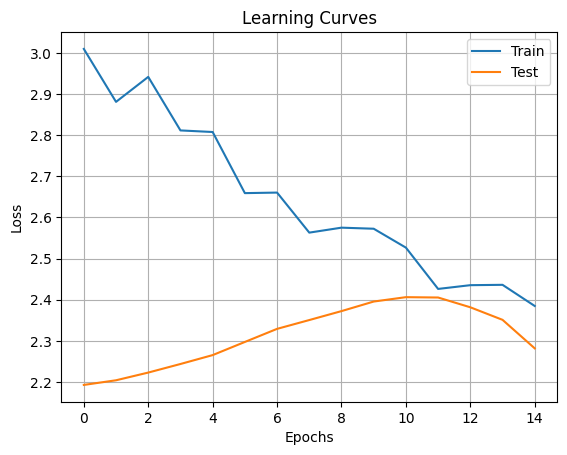

In [ ]:
# learning curves
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Evaluate the model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== Train ===
              precision    recall  f1-score   support

    negative      0.333     1.000     0.500       336
     neutral      0.000     0.000     0.000       336
    positive      0.000     0.000     0.000       336

    accuracy                          0.333      1008
   macro avg      0.111     0.333     0.167      1008
weighted avg      0.111     0.333     0.167      1008



/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


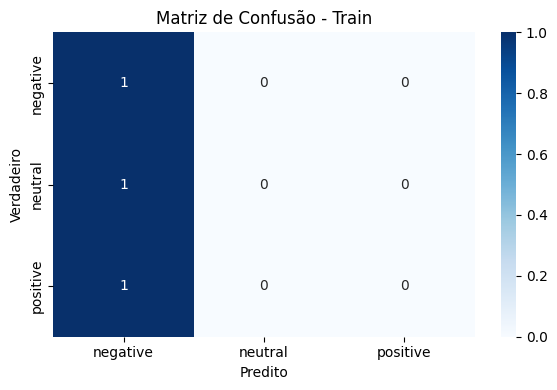

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== Test ===
              precision    recall  f1-score   support

    negative      0.122     1.000     0.217        84
     neutral      0.000     0.000     0.000       429
    positive      0.000     0.000     0.000       178

    accuracy                          0.122       691
   macro avg      0.041     0.333     0.072       691
weighted avg      0.015     0.122     0.026       691



/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


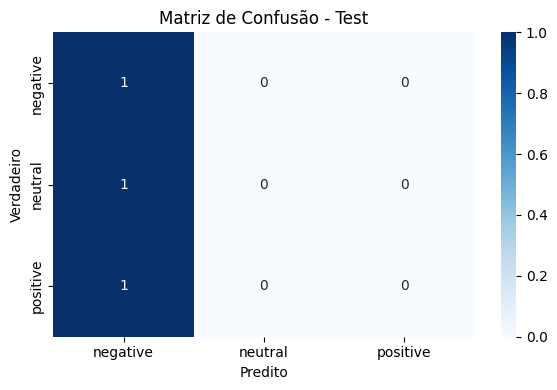

In [ ]:
def print_metrics(X, y, title):
    y_pred_probs = model.predict(X)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"=== {title} ===")
    print(classification_report(np.argmax(y, axis=1), y_pred, target_names=[id2label[i] for i in range(3)], digits=3))

    cm = confusion_matrix(np.argmax(y, axis=1), y_pred, normalize='true')
    labels = [id2label[i] for i in range(3)]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - {title}')
    plt.tight_layout()
    plt.show()

print_metrics(X_train, y_train, "Train")
print_metrics(X_test, y_test, "Test")